# Implementing Change in bicoin price over timeseries with RNN and LSTM

In [1]:
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import math

Using TensorFlow backend.


In [2]:
def extract_datafrom_csv(filename, sequence_length):
    
    #Read file
    rawdata = pd.read_csv(filename, dtype = float).values
    #Changing all zeros to the number before the zero occurs
    for i in range(0, rawdata.shape[0]):
        for j in range(0, rawdata.shape[1]):
            if(rawdata[i][j] == 0):
                #print("i=",i,"j=",j)
                rawdata[i][j] = rawdata[i-1][j]
                #print(data[i][j])
    
    #Converting file to a list
    data = rawdata.tolist()
    print(len(data))
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    
    #Keeping the unnormalized prices for Y_test
    #required to plot graph of bitcoin price over time 
    start = 2400
    end = int(dr.shape[0] + 1)
    unnormalized_bases = d0[start:end,0:1,20]
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:, :-1]
    Y_train = training_data[:, -1]
    Y_train = Y_train[:, 20]
    
    #Testing data
    X_test = dr[int(split_line):, :-1]
    Y_test = dr[int(split_line):, 49, :]
    Y_test = Y_test[:, 20]

    #Get the day before Y_test's price
    Y_daybefore = dr[int(split_line):, 48, :]
    Y_daybefore = Y_daybefore[:, 20]
    
    #Get window size and sequence length
    sequence_length = sequence_length
    window_size = sequence_length - 1 #because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

In [4]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = extract_datafrom_csv("Bitcoin Data.csv", 50)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print (Y_daybefore.shape)
print (unnormalized_bases.shape)
print (window_size)

2717
(2400, 49, 35)
(2400,)
(267, 49, 35)
(267,)
(267,)
(267, 1)
49


## Building the Model

In [8]:
def build_model(window_size, dropout_value, activation_function, loss_function, optimizer):
    
    #Creating Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((window_size*2), return_sequences=True)))
    model.add(Dropout(dropout_value))

    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer - returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

In [12]:
model = build_model(window_size, 0.2, 'linear', 'mse', 'adam')
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 49, 98)            33320     
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 98)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 99        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

## Training the Model

In [13]:
def train_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    #time tooen to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

In [14]:
model, training_time = train_model(model, X_train, Y_train, 1024, 100, .05)

print ("Training time", training_time, "seconds")

C:\Users\pvpan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Instructions for updating:
Use tf.cast instead.
Train on 2280 samples, validate on 120 samples
Epoch 1/100
2280/2280 [==============================] - 46s 20ms/step - loss: 2.9128 - val_loss: 1.6877
Epoch 2/100
2280/2280 [==============================] - 8s 4ms/step - loss: 2.2083 - val_loss: 1.1802
Epoch 3/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.8051 - val_loss: 0.7834
Epoch 4/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.4318 - val_loss: 0.5971
Epoch 5/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.2335 - val_loss: 0.6135
Epoch 6/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.0419 - val_loss: 0.5800
Epoch 7/100
2280/2280 [==============================] - 8s 4ms/step - loss: 0.8180 - val_loss: 0.4805
Epoch 8/100
2280/2280 [==============================] - 8s 4ms/step - loss: 0.6714 - val_loss: 0.3481
Epoch 9/100
2280/2280 [==============================] - 8s 4ms/step - loss: 0.

## Testing the Model


In [15]:
def test_model(model, X_test, Y_test, unnormalized_bases):
    #Testing the model on X_Test
    y_predict = model.predict(X_test)

    #Creating empty arrays to store unnormalized values
    real_y_test = np.zeros_like(Y_test)
    real_y_predict = np.zeros_like(y_predict)

    #Fill arrays with the real value and the predicted value by reversing the normalization process
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        predict = y_predict[i]
        real_y_test[i] = (y+1)*unnormalized_bases[i]
        real_y_predict[i] = (predict+1)*unnormalized_bases[i]

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(real_y_test, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price in USD")
    ax.set_xlabel("Time in Days")
    ax.legend()
    
    return y_predict, real_y_test, real_y_predict, fig

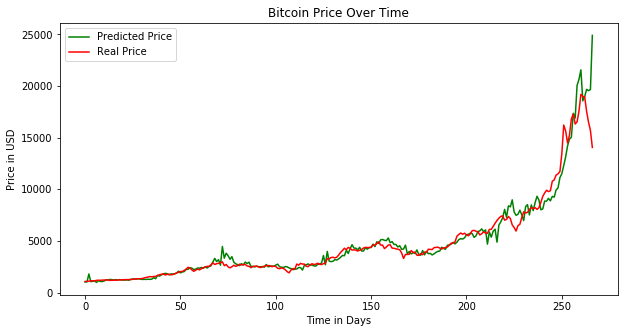

In [16]:
y_predict, real_y_test, real_y_predict, fig1 = test_model(model, X_test, Y_test, unnormalized_bases)

#Show the plot
plt.show(fig1)

## Evaluating Price Change

In [17]:
def evaluate_price_change(Y_daybefore, Y_test, y_predict):
    #Reshaping Y_daybefore and Y_test
    Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
    Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
    delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

    #The difference between each true value and the value from the day before
    delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

    #Plotting the predicted percent change versus the real percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_real, color='red', label = 'Real Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return Y_daybefore, Y_test, delta_predict, delta_real, fig

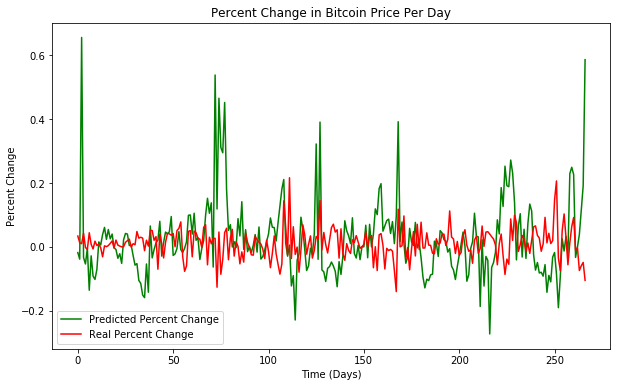

In [18]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = evaluate_price_change(Y_daybefore, Y_test, y_predict)

#Show the plot
plt.show(fig2)

In [19]:
def convert_to_binary_price(delta_predict, delta_real):
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    delta_predict_1_0 = np.empty(delta_predict.shape)
    delta_real_1_0 = np.empty(delta_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_1_0[i][0] = 1
        else:
            delta_predict_1_0[i][0] = 0
    for i in range(delta_real.shape[0]):
        if delta_real[i][0] > 0:
            delta_real_1_0[i][0] = 1
        else:
            delta_real_1_0[i][0] = 0    

    return delta_predict_1_0, delta_real_1_0

In [20]:
delta_predict_1_0, delta_real_1_0 = convert_to_binary_price(delta_predict, delta_real)

print (delta_predict_1_0.shape)
print (delta_real_1_0.shape)

(267, 1)
(267, 1)


## Comparing Prediction and Real Data


In [21]:
def convertto_positives_negatives(delta_predict_1_0, delta_real_1_0):
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_real_1_0.shape[0]):
        real = delta_real_1_0[i][0]
        predicted = delta_predict_1_0[i][0]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

In [22]:
true_pos, false_pos, true_neg, false_neg = convertto_positives_negatives(delta_predict_1_0, delta_real_1_0)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 85
False positives: 58
True negatives: 41
False negatives: 83


## Calculating Statistics

In [23]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
 
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, MSE

In [24]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)
print ("Precision:", precision)
print ("Recall:", recall)
print ("F1 score:", F1)
print ("Mean Squared Error:", MSE)

Precision: 0.5944055944055944
Recall: 0.5059523809523809
F1 score: 0.5466237942122186
Mean Squared Error: 0.056301157616007916
